### Imports

In [32]:
import os

# NOTE: Importing torch the first time will always take a long time!
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.data import Dataset

# from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from skimage.metrics import structural_similarity
# from skimage.metrics import peak_signal_noise_ratio

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

# import wandb # Optional, for logging


In [33]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/venv/bin/python


Torch version: 2.3.0+cu121
Path: /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/scripts/dyn_img_static


In [34]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [35]:
DISABLING_TESTS = False
# DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [36]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

torch.set_default_device(DEVICE)

Using NVIDIA GeForce RTX 4090


### Configs

In [37]:
DATA_PATH = "./SIDD_Small_sRGB_Only/Data"

------

### Import the image and transform the data

#### Download the data

In [38]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

#### Take a single image

In [39]:
def get_npy_file(sample_path: str, scale_factor: float) -> np.ndarray:			
    scale_factor_str = str(scale_factor).replace('.','_')
    xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [40]:
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images(ids: list, take_npy_files: bool) -> list:
    data_path = DATA_PATH
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images

        images.append(image)

    return images

loading image id 0065, 1/1
(4048, 3044)


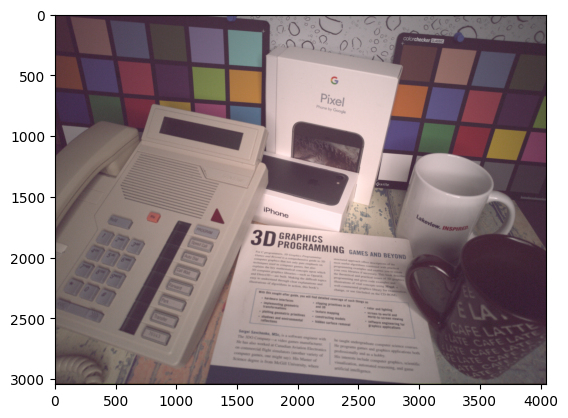

In [41]:
def test_load_images():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        print(img.size)
        plt.imshow(img)

test_load_images()

------

#### Convert image to grayscale

In [42]:
def convert_to_grayscale(image: Image) -> Image:
    return image.convert('L')

loading image id 0065, 1/1


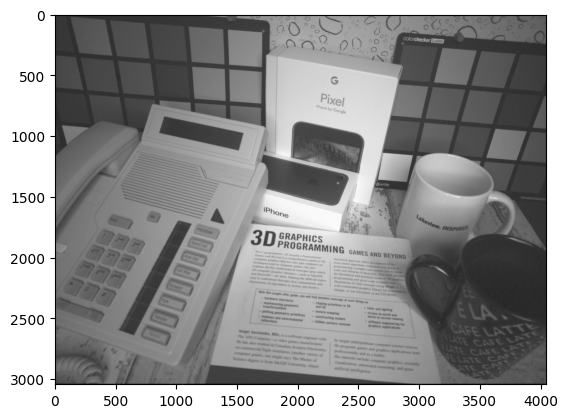

In [43]:
def test_convert_to_grayscale():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Resize image

<!-- (Optional) Rescale the image

Make the image a bit smaller

Example:

Original 5328 x 3000

Recaled 0.5 to 2664 x 1500 -->

In [44]:
def resize_image(image, scale_factor):
    Nx_,Ny_ = int(np.floor(scale_factor * image.width )), int(np.floor(scale_factor * image.height ))
    image = image.resize( (Nx_, Ny_) )
    return image

loading image id 0065, 1/1
(202, 152)


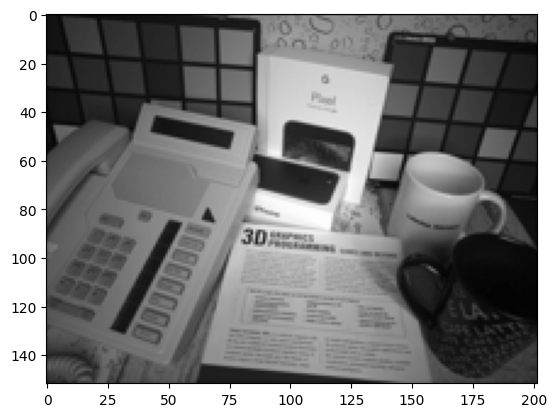

In [45]:
def test_resize_image():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        img = resize_image(img, 0.05) # Extreme size reduction for demonstration
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_resize_image()

#### Convert to numpy array

In [46]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

loading image id 0065, 1/1


Before conversion: <class 'PIL.Image.Image'>
After conversion: <class 'numpy.ndarray'>


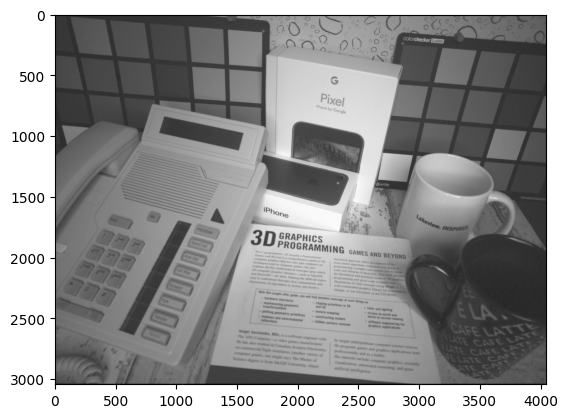

In [47]:
def test_convert_to_numpy():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

#### Convert to tensor

For efficient computation on GPU

In [48]:
def convert_to_tensor_4D(image_numpy):
    # xf = []
    # xf.append(image_numpy)
    # xf = np.stack(xf, axis=-1)
    # xf = torch.tensor(xf, dtype=torch.float)
    xf = torch.tensor(image_numpy, dtype=torch.float)
    xf = xf.unsqueeze(0)
    xf = xf.unsqueeze(-1)
    xf = xf / 255 # Normalise from [0, 255] to [0, 1]
    return xf

loading image id 0065, 1/1
torch.Size([1, 3044, 4048, 1])


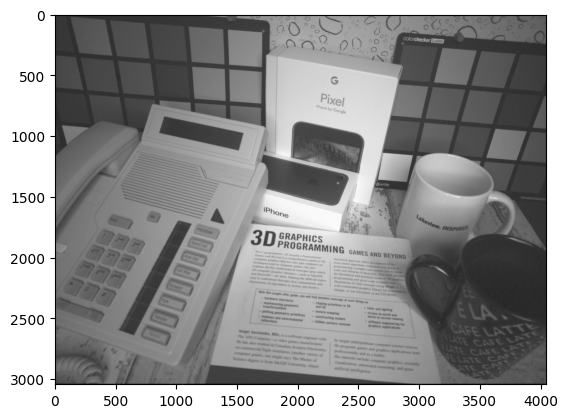

In [49]:
def test_convert_to_tensor():
    if DISABLING_TESTS: return
    for image in load_images(["0065"], False):
        image = convert_to_grayscale(image)
        image_numpy = convert_to_numpy(image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(image_tensor_4D.size())
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')

    with torch.no_grad():
        torch.cuda.empty_cache()

test_convert_to_tensor()

#### Add synthetic noise

<!-- artificial Gaussian noise

Noise can occur in reality.

It is difficult to obtain a pair of clean and noisy images of one exact same scene.

For training, it is common to add synthetic noise to an image that is considered clean and then try to reconstruct it.

There are many types of noise and different ways to add noise. We can add salt-and-pepper noise. (?)We can add more noise in some parts and less in others. We can use a combination of noise-adding strategies to build more robust models.

For our purpose, we will focus on Gaussian noise. This is sufficient for most cases. 

(?) We will add noise with the same probability for each pixel (not using the strategies of focusing on certain regions) -->

In [50]:
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

loading image id 0065, 1/1
grayscale_image.size: (202, 152)


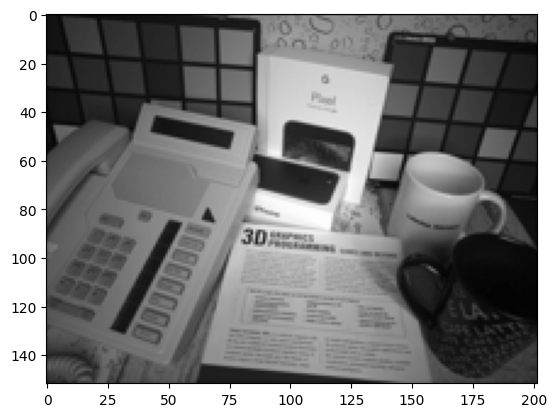

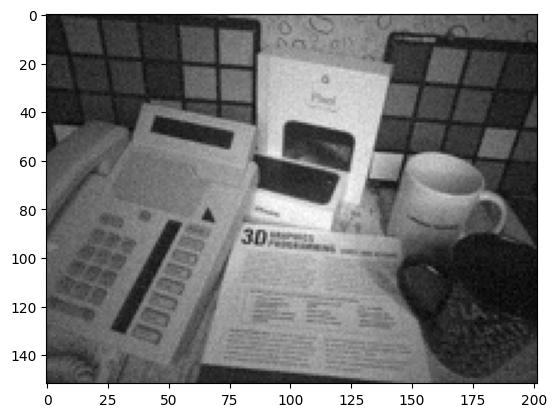

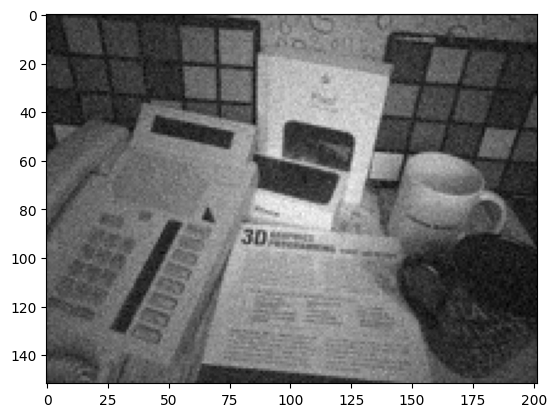

In [51]:
def test_add_noise():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.05)
        print(f"grayscale_image.size: {grayscale_image.size}")
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        constant_noise_img = add_noise(image_tensor_4D, sigma=0.1)
        variable_noise_img = add_noise(image_tensor_4D, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(grayscale_image, cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()
        
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

In [52]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0): # MSE is zero means no noise is present in the signal. 
                  # Therefore PSNR have no importance. 
        return 100
    # max_pixel = 255.0
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr

loading image id 0065, 1/1
PSNR of original image: 100 dB


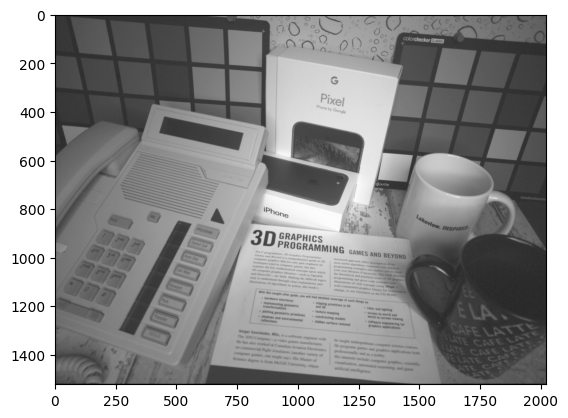

PSNR of constant noise image: 20.21 dB


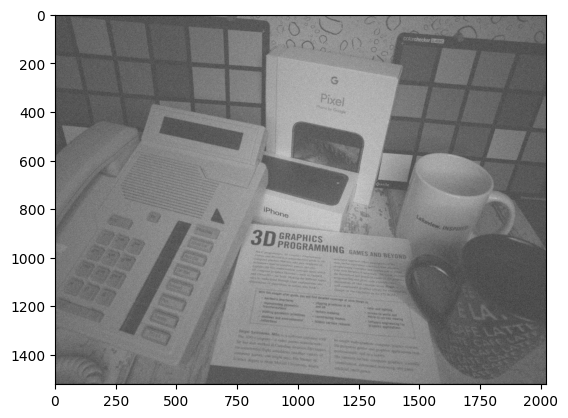

In [53]:
def test_PSNR():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.5)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        print(f"PSNR of original image: {PSNR(image_tensor_4D, image_tensor_4D)} dB")
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=0.5)
        print(f"PSNR of constant noise image: {PSNR(noisy_image_tensor_4D, image_tensor_4D):.2f} dB")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

test_PSNR()

---

### Calculate SSIM

In [54]:
def SSIM(tensor_2D_a: torch.Tensor, tensor_2D_b: torch.Tensor, data_range: float=1) -> float:
    return structural_similarity(
        tensor_2D_a.cpu().numpy(), 
        tensor_2D_b.cpu().numpy(), 
        data_range=data_range)

loading image id 0065, 1/1
image_tensor_2D: torch.Size([1522, 2024])
SSIM of original image: 1.0


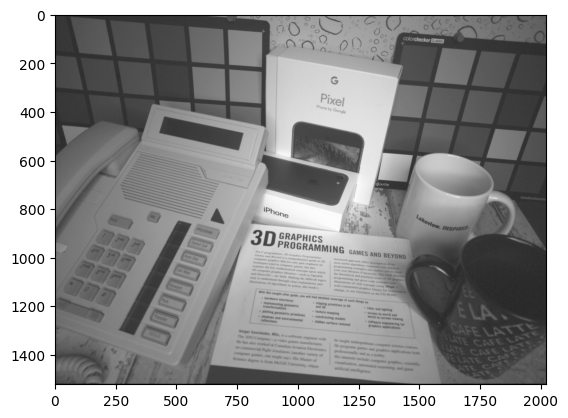

noisy_image_tensor_2D: torch.Size([1522, 2024])
SSIM of noisy image (sigma=0.5): 0.18


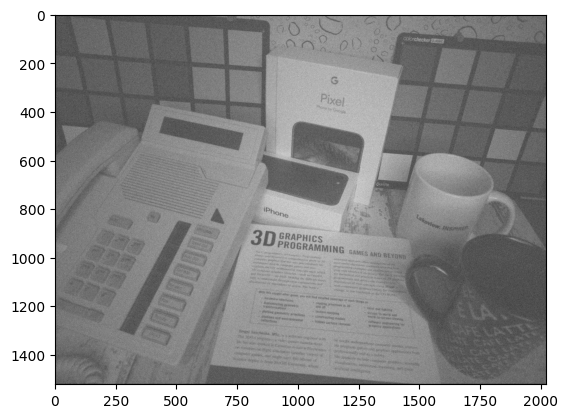

In [55]:
def test_SSIM(sigma=0.5):
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.5)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        image_tensor_2D = image_tensor_4D.squeeze(0).squeeze(-1)
        print(f"image_tensor_2D: {image_tensor_2D.size()}")
        print(f"SSIM of original image: {SSIM(image_tensor_2D, image_tensor_2D)}")
        plt.imshow(image_tensor_2D.cpu(), cmap='gray')
        plt.show();

        noisy_image_tensor_2D = add_noise(image_tensor_2D, sigma=sigma)
        print(f"noisy_image_tensor_2D: {noisy_image_tensor_2D.size()}")
        print(f"SSIM of noisy image (sigma={sigma}): {SSIM(noisy_image_tensor_2D, image_tensor_2D):.2f}")
        plt.imshow(noisy_image_tensor_2D.cpu(), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

test_SSIM()

------

### Reconstruct an image with PDHG

#### Calculate the gradient

<!-- The gradient is a Laplacian ?

There are $x$ gradient and $y$ gradient -->

In [56]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])
        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])
        return y
    
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)
        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)

    @property
    def normGHG(self):
        return self._norm

#### Helper function for PDHG: Clip act

In [57]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x

#### Only PDHG

For some reason, running PDHG with T large (many iterations in PDGH) will make GPU memory full?

In [58]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

def reconstruct_with_PDHG(x_dynamic_image_tensor_5D, lambda_reg, T, lambda_reg_container=[]):
    """
    Reconstructs the image using the PDHG algorithm.

    Parameters:
        dynamic_image_tensor_5D: The (noisy) (dynamic) image tensor.
        Size of the tensor: (`patches`, `channels`, `Nx`, `Ny`, `Nt`) where
        
        - `patches`: number of patches
        - `channels`: number of (colour) channels
        - `Nx`: number of pixels in x
        - `Ny`: number of pixels in y
        - `Nt`: number of time steps (frames)

        lambda_reg: The regularization parameter. Can be a scalar or a tensor of suitable size.
        T: Number of iterations.

    Returns:
        The reconstructed image tensor.
    """

    dim = 3
    patches, channels, Nx, Ny, Nt = x_dynamic_image_tensor_5D.shape
    
    assert channels == 1, "Only grayscale images are supported."

    device = x_dynamic_image_tensor_5D.device

    # starting values
    xbar = x_dynamic_image_tensor_5D.clone()
    x0 = x_dynamic_image_tensor_5D.clone()
    xnoisy = x_dynamic_image_tensor_5D.clone()

    # dual variable
    p = x_dynamic_image_tensor_5D.clone()
    q = torch.zeros(patches, dim, Nx, Ny, Nt, dtype=x_dynamic_image_tensor_5D.dtype).to(device)

    # operator norms
    op_norm_AHA = torch.sqrt(torch.tensor(1.0))
    op_norm_GHG = torch.sqrt(torch.tensor(12.0))
    # operator norm of K = [A, \nabla]
    # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
    # see page 3083
    L = torch.sqrt(op_norm_AHA**2 + op_norm_GHG**2)

    tau = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L
    sigma = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L

    # theta should be in \in [0,1]
    theta = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1

    # sigma, tau, theta
    sigma = (1 / L) * torch.sigmoid(sigma)  # \in (0,1/L)
    tau = (1 / L) * torch.sigmoid(tau)  # \in (0,1/L)
    theta = torch.sigmoid(theta)  # \in (0,1)

    GradOps = GradOperators(
        dim=dim, 
        mode="forward", padmode="circular")
    clip_act = ClipAct()
    # Algorithm 2 - Unrolled PDHG algorithm (page 18)
    # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
    for kT in range(T):
        # update p
        p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
        # update q
        q = clip_act(q + sigma * GradOps.apply_G(xbar), lambda_reg)

        x1 = x0 - tau * p - tau * GradOps.apply_GH(q)

        if kT != T - 1:
            # update xbar
            xbar = x1 + theta * (x1 - x0)
            x0 = x1
        with torch.no_grad():
            torch.cuda.empty_cache()

    with torch.no_grad():
        torch.cuda.empty_cache()

    lambda_reg_container.append(lambda_reg) # For comparison

    return x1

loading image id 0065, 1/1
Image tensor size: torch.Size([1, 380, 506, 1])


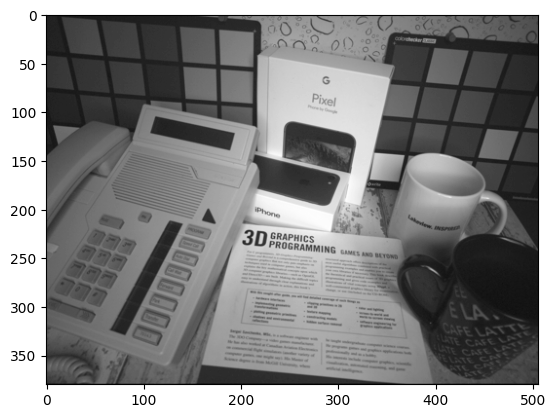

PSNR of constant noise image: 20.29 dB
SSIM of constant noise image: 0.30


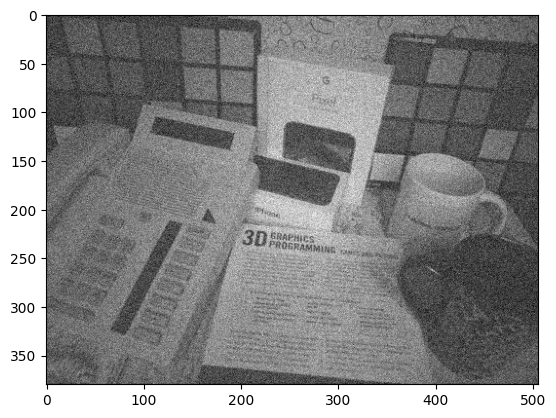

PDHG input size: torch.Size([1, 1, 380, 506, 1])
PSNR of reconstructed image: 28.20 dB


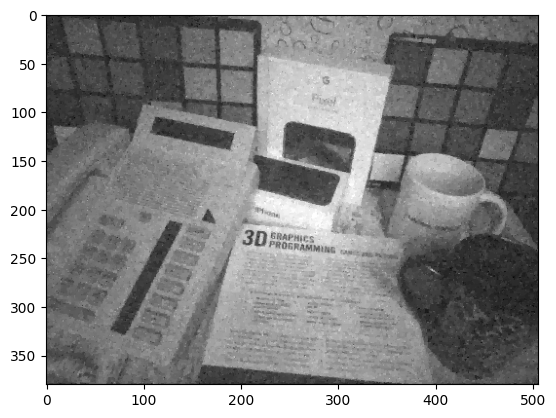


In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.



In [59]:
def test_reconstruct_with_PDHG():
    if DISABLING_TESTS: return
    # for rgb_image in load_images(["0001"], False):
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.125)
        image_numpy = convert_to_numpy(grayscale_image)

        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(f"Image tensor size: {image_tensor_4D.size()}")
        assert len(image_tensor_4D.size()) == 4, "The image should be 4D"
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_tensor_4D, noisy_image_tensor_4D):.2f} dB")
        print(f"SSIM of constant noise image: {SSIM(image_tensor_4D.squeeze(0).squeeze(-1), noisy_image_tensor_4D.squeeze(0).squeeze(-1)):.2f}")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_LAMBDA = 0.04
        pdhg_input_tensor_5D = noisy_image_tensor_4D.unsqueeze(0)
        print(f"PDHG input size: {pdhg_input_tensor_5D.size()}")
        assert len(pdhg_input_tensor_5D.size()) == 5, "The input for PDHG should be 5D"
        denoised_image_tensor_5D = reconstruct_with_PDHG(
            pdhg_input_tensor_5D, 
            lambda_reg=TEST_LAMBDA, 
            T=128)
        
        denoised_image_tensor_5D = torch.clamp(denoised_image_tensor_5D, 0, 1) # Clip the values to 0 and 1
        psnr_value_denoised = PSNR(image_tensor_4D, denoised_image_tensor_5D.squeeze(0))
        print(f"PSNR of reconstructed image: {psnr_value_denoised:.2f} dB")
        denoised_image_numpy_3D = denoised_image_tensor_5D.squeeze(0).squeeze(0).to("cpu").detach().numpy()
        plt.imshow(denoised_image_numpy_3D, cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()

------

### Full Architecture

<!-- UNET to PDHG

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map. -->

In [60]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class DynamicImageStaticPrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        mode="lambda_cnn",
        up_bound=0,
        phase="training",
    ):
        # print(f"Running: {DynamicImageStaticPrimalDualNN.__name__}")
        super(DynamicImageStaticPrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        if mode == "lambda_xyt":
            # one single lambda for x,y and t
            self.lambda_reg = nn.Parameter(torch.tensor([-1.5]), requires_grad=True)

        elif mode == "lambda_xy_t":
            # one (shared) lambda for x,y and one lambda for t
            self.lambda_reg = nn.Parameter(
                torch.tensor([-4.5, -1.5]), requires_grad=True
            )

        elif mode == "lambda_cnn":
            # the CNN-block to estimate the lambda regularization map
            # must be a CNN yielding a two-channeld output, i.e.
            # one map for lambda_cnn_xy and one map for lambda_cnn_t
            self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
            self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T
        self.mode = mode

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        print(f"self.phase: {self.phase}")
        print(f"up_bound: {self.up_bound}")
        print(f"lambda_cnn: {lambda_cnn.size()}")

        return lambda_cnn

    def forward(self, x, lambda_map=None, lambda_reg_container=[]):
        if lambda_map is None:
            # estimate lambda reg from the image
            lambda_reg = self.get_lambda_cnn(x)
        else:
            lambda_reg = lambda_map

        lambda_reg_container.append(lambda_reg) # For comparison

        x.to(DEVICE)
        x1 = reconstruct_with_PDHG(x, lambda_reg, self.T)
        return x1

------

### Data loading class

In [61]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class DynamicImageStaticDenoisingDataset(Dataset):
	
	def __init__(
		self, 
		data_path: str, 
		ids: list,
		scale_factor = 0.5, 
		sigma=0.23,  
		patches_size = None,
		strides= None,
		extract_data=True,
		device: str = "cuda"
	):
		self.device = device
		self.scale_factor = scale_factor

		ids = [str(x).zfill(2) for x in ids]

		xf_list = []
  
		k = 0
		# for k, img_id in enumerate(ids):
		for folder in os.listdir(data_path):
			img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
			if img_id not in ids:
				continue
			k += 1
			print(f'loading image id {img_id}, {k}/{len(ids)}')
			# sample_path = os.path.join(data_path, f"MOT17-{img_id}")
			sample_path = os.path.join(data_path, folder)
			if extract_data:
				xf = self.create_dyn_img(sample_path)
			else:
				scale_factor_str = str(self.scale_factor).replace('.','_')
				xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
				
			xf = torch.tensor(xf, dtype=torch.float)
			xf = xf.unsqueeze(0) / 255
			
			if patches_size is not None:
				
				print(f"extracting patches of shape {patches_size}; strides {strides}")
				xf_patches = extract_patches_3d(xf.contiguous(), patches_size, stride=strides)
				xf_list.append(xf_patches)
			
		if patches_size is not None:
			# will have shape (mb, 1, Nx, Ny, Nt), where mb denotes the number of patches
			xf = torch.concat(xf_list,dim=0)
			
		else:
			xf = xf.unsqueeze(0)
		
		#create temporal TV vector to detect which patches contain the most motion
		xf_patches_tv = (xf[...,1:] - xf[...,:-1]).pow(2).sum(dim=[1,2,3,4]) #contains the TV for all patches
		
		#normalize to 1 to have a probability vector
		xf_patches_tv /= torch.sum(xf_patches_tv)
		
		#sort TV in descending order --> xfp_tv_ids[0] is the index of the patch with the most motion
		self.samples_weights = xf_patches_tv

		# TODO: Investigate
		# Change the values in samples_weights to be a range of integers from 0 to len(samples_weights)
		# Unless I do this, when I run on a set of identical images, it will give me an error:
		# RuntimeError: invalid multinomial distribution (encountering probability entry < 0)
		self.samples_weights = torch.arange(len(self.samples_weights))
		
		self.xf = xf
		self.len = xf.shape[0]
		
		if isinstance(sigma, float):
			self.noise_level = 'constant'
			self.sigma = sigma

		elif isinstance(sigma, (tuple, list)):
			self.noise_level = 'variable'
			self.sigma_min = sigma[0]
			self.sigma_max = sigma[1]
		
		else:
			raise ValueError("Invalid sigma value provided, must be float, tuple or list.")

	def create_dyn_img(self, sample_path: str):
		
		files_path = sample_path
		files_list = os.listdir(files_path)
		xf = []

		for file in files_list:
			if not file.startswith('GT'):
				continue
			image = Image.open(os.path.join(files_path, file))
			
			#resize
			Nx_,Ny_ = int(np.floor(self.scale_factor * image.width )), int(np.floor(self.scale_factor * image.height ))
			image = image.resize( (Nx_, Ny_) )
			
			
			image = image.convert('L') #convert to grey_scale
			image_data = np.asarray(image)
			xf.append(image_data)
			
		xf = np.stack(xf, axis=-1)
		
		scale_factor_str = str(self.scale_factor).replace('.','_')
		np.save(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"), xf)
		
		return xf
			
	def __getitem__(self, index):

		std = torch.std(self.xf[index])
		mu = torch.mean(self.xf[index])

		x_centred = (self.xf[index]  - mu) / std

		if self.noise_level == 'constant':
			sigma = self.sigma
			
		elif self.noise_level == 'variable':
			sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

		x_centred += sigma * torch.randn(self.xf[index].shape, dtype = self.xf[index].dtype)

		xnoise = std * x_centred + mu
  
		return (
			xnoise.to(device=self.device),
   			self.xf[index].to(device=self.device)
        )
		
	def __len__(self):
		return self.len

------

### Create data loader

In [62]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Configurations

In [63]:
# # Code adapted from ...

# # Ids are in the form of 4 character strings "0001" to "0200"
# TRAINING = [str(x).zfill(4) for x in range(54, 74)]
# print(f"TRAINING: {TRAINING}")

# VALIDATION = ["0065"] # TODO: Decide what to use for validation

# data_path = "./SIDD_Small_sRGB_Only/Data"
# # Make sure that the dataset was downloaded successfully
# # The data samples can be created with different scaling factors.
# # Make sure to set extract_data to True when loading the dataset for the first time to create the dynamic images.
# # Once the data for a specific scaling factor has been created the flag can be set to False.
# dataset_train = DynamicImageStaticDenoisingDataset(
#     data_path=data_path,
#     # ids=TRAINING,     
#     ids=["0065"],       # testing
#     scale_factor=0.5,
#     # sigma=[0.1, 0.3],
#     # sigma=[0.3, 0.3],
#     sigma=[0.5, 0.5],
#     # strides=[192, 192, 1],
#     # patches_size=[192, 192, 1],
#     strides=[512, 512, 1],
#     patches_size=[512, 512, 1],
#     # (!) Make sure to set the following flag to True when loading the dataset for the first time.
#     extract_data=True,
#     # extract_data=False,
#     device=DEVICE
# )

# # Create training dataloader
# sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=sampler)

# # Validation dataset (see note above)
# dataset_valid = DynamicImageStaticDenoisingDataset(
#     data_path=data_path,
#     # ids=VALIDATION,   
#     ids=["0065"],       # testing
#     scale_factor=0.25,
#     # sigma=[0.1, 0.3],
#     # sigma=[0.3, 0.3],
#     sigma=[0.5, 0.5],
#     # strides=[192, 192, 1],
#     # patches_size=[192, 192, 1],
#     strides=[512, 512, 1],
#     patches_size=[512, 512, 1],
#     # (!) Make sure to set the following flag to True when loading the dataset for the first time.
#     extract_data=True,
#     # extract_data=False,
#     device=DEVICE
# )

# # Create validation dataloader 
# sampler = WeightedRandomSampler(dataset_valid.samples_weights, len(dataset_valid.samples_weights))
# dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1, sampler=sampler)

# with torch.no_grad():
#     torch.cuda.empty_cache()

In [64]:
# def test_dataloader():
#     dataloader_example = DynamicImageStaticDenoisingDataset(
#     data_path=data_path,
#     # ids=TRAINING,     
#     ids=["0065"],       # testing
#     scale_factor=0.5,
#     # sigma=[0.1, 0.3],
#     # sigma=[0.3, 0.3],
#     sigma=[0.5, 0.5],
#     # strides=[192, 192, 1],
#     # patches_size=[192, 192, 1],
#     strides=[512, 512, 1],
#     patches_size=[512, 512, 1],
#     # (!) Make sure to set the following flag to True when loading the dataset for the first time.
#     extract_data=True,
#     # extract_data=False,
#     device=DEVICE
#     )
#     for i, (x, y) in enumerate(dataloader_example):
#         print(f"Batch {i}")
#         print(f"x size: {x.size()}")
#         print(f"y size: {y.size()}")
#         plt.imshow(x.squeeze(0).to("cpu"), cmap='gray')
#         plt.show();
#         plt.imshow(y.squeeze(0).to("cpu"), cmap='gray')
#         plt.show();
#         if i == 0:
#             break
            
# test_dataloader()

------

### UNET

The specific UNET architecture we use has the following parts:

...

We use Leaky RELU instead of RELU or Sigmoid.

In [65]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01)
        )

    def forward(self, x):
        return self.conv_block(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList([
            # ConvBlock(1, 16),
            # ConvBlock(16, 32),
            # ConvBlock(32, 64),
            ConvBlock(1, 64),  # NOTE: Imitating the original UNet
            ConvBlock(64, 128),  # NOTE: Trying to add one more block
            ConvBlock(128, 256),  # NOTE: Trying to add two more blocks
            # ConvBlock(256, 512),  # NOTE: Trying to add three more blocks
            # ConvBlock(512, 1024),  # NOTE: Imitating the original UNet
        ])
        self.pool = nn.MaxPool3d(kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        enc_features = []
        for block in self.enc_blocks:
            x = block(x)
            enc_features.append(x)
            x = self.pool(x)
        return enc_features

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconvs = nn.ModuleList([
            # nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1),  # NOTE: Imitating the original UNet
            # nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add three more blocks
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add two more blocks
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add one more block
            # nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            # nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1),
        ])
        self.dec_blocks = nn.ModuleList([
            # ConvBlock(1024, 512),  # NOTE: Imitating the original UNet
            # ConvBlock(512, 256),  # NOTE: Trying to add three more blocks
            ConvBlock(256, 128),  # NOTE: Trying to add two more blocks
            ConvBlock(128, 64),  # NOTE: Trying to add one more block
            # ConvBlock(64, 32),
            # ConvBlock(32, 16),
        ])

    def forward(self, x, enc_features):
        for i in range(len(self.upconvs)):
            x = self.upconvs[i](x)
            x = torch.cat((x, enc_features[i]), dim=1)  # concatenate along the channel axis
            x = self.dec_blocks[i](x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        # self.c1x1 = nn.Conv3d(16, 2, kernel_size=1, stride=1, padding=0)
        self.c1x1 = nn.Conv3d(64, 2, kernel_size=1, stride=1, padding=0)    # NOTE: Imitating the original UNet

    def forward(self, x):
        enc_features = self.encoder(x)
        x = self.decoder(enc_features[-1], enc_features[::-1][1:]) # remove the last element and reverse the list
        x = self.c1x1(x)
        return x

def test_unet():
    # Example usage
    model = UNet()
    # input_tensor = torch.randn(1, 1, 64, 64, 64)  # batch size of 1, 1 channel, 64x64x64 volume
    input_tensor = torch.randn(1, 1, 512, 512, 1)  # batch size of 1, 1 channel, 64x64x64 volume
    output = model(input_tensor)
    # print(output.shape)  # should be (1, 2, 64, 64, 64)
    print(output.shape)  # should be (1, 2, 512, 512, 1)

    print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # Delete the model and the output tensor
    del model
    del output
    torch.cuda.empty_cache()

test_unet()
with torch.no_grad():
    torch.cuda.empty_cache()

torch.Size([1, 2, 512, 512, 1])

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d

------

### Training

#### Code for one epoch

In [66]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

def train_iteration(optimizer, model, loss_func, sample):
    optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
    noisy_image, clean_image = sample
    # print(f"noisy_image size: {noisy_image.size()}")
    # print(f"clean_image size: {clean_image.size()}")
    denoised_image = model(noisy_image)
    loss = loss_func(denoised_image, clean_image)
    loss.backward()
    
    if loss.item() != loss.item():
        raise ValueError("NaN returned by loss function...")

    optimizer.step()

    psnr = PSNR(denoised_image, clean_image)
    ssim = SSIM(denoised_image.squeeze(0), clean_image.squeeze(0))

    return loss.item(), psnr, ssim

def train_epoch(model, data, optimizer, loss_func) -> float:
    """Perform the training of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with training data
    optimizer
        Pytorch optimizer, e.g. Adam
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        training loss

    Raises
    ------
    ValueError
        loss is NaN
    """
    running_loss = 0.

    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        running_loss += train_iteration(optimizer, model, loss_func, sample)

    return running_loss / len(data.dataset)



def validate_iteration(model, loss_func, sample):
    noisy_image, clean_image = sample
    denoised_image = model(noisy_image)
    loss = loss_func(denoised_image, clean_image)

    psnr = PSNR(denoised_image, clean_image)
    ssim = SSIM(denoised_image.squeeze(0), clean_image.squeeze(0))

    return loss.item(), psnr, ssim

def validate_epoch(model, data, loss_func) -> float:
    """Perform the validation of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with validation data
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        validation loss
    """
    running_loss = 0.
    
    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        running_loss += validate_iteration(model, loss_func, sample)

    return running_loss / len(data.dataset)


#### Optional: Use wandb to log the training process

In [67]:
# # Optional: Use wandb to log the training process
# !wandb login

# os.environ['WANDB_NOTEBOOK_NAME'] = 'image-denoising-turtle'
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="image-denoising-turtle",

#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "optimizer": "Adam",
#     "loss_function": "MSELoss",
#     "architecture": "UNET-PDHG",
#     # "up_bound": 0.5,
#     "up_bound": 0,
#     # "dataset": "SIDD_Small-img_0065_only",
#     # "dataset": "All_SIDD_Small",
#     "dataset": "turtle",
#     # "scale_factor": 0.25,
#     "scale_factor": 1,
#     # "scale_factor": 0.5,
#     # "kernel_size": 192,
#     "kernel_size": 256,
#     # "kernel_size": 512,
#     # "sigma": 1,
#     # "sigma": 0.5,
#     # "sigma": 0.3,
#     "sigma": "NA",
#     # "T": 32,
#     # "T": 128,
#     "T": 1024,
#     # "T": 200,
#     "activation": "LeakyReLU",
#     "epochs": 10_000,
#     "unet_size": "small-16-32-64",
#     }
# )

#### Prep for training

In [68]:
with torch.no_grad():
    torch.cuda.empty_cache()

#### My dataset class

In [69]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, noisy_image_path, clean_image_path):
        self.noisy_image_path = noisy_image_path
        self.clean_image_path = clean_image_path

    def get_image(self, image_path):
        image = Image.open(image_path)
        image = image.convert("L")
        image_data = np.asarray(image)
        image_data = convert_to_tensor(image_data)
        image_data = image_data.unsqueeze(0).unsqueeze(0).to(DEVICE)

    # get sample
    def __getitem__(self, idx):
        noisy_image = self.get_image(self.noisy_image_path)
        clean_image = self.get_image(self.clean_image_path)
        print(f"Noisy image size: {noisy_image.size()}")
        print(f"Clean image size: {clean_image.size()}")
        return noisy_image, clean_image

    def __len__(self):
        return 1

#### Start training

In [70]:
# # Code adapted from https://www.github.com/koflera/LearningRegularizationParameterMaps

# config = {
#     "max_epochs": 1000,
#     "learning_rate": 1e-4,
#     "save_epoch": 2,
#     "T": 128,
#     # "up_bound": 0.8,
#     # "up_bound": 0.5,
#     "up_bound": 0,
# }

# # Define CNN block
# unet = UNet().to(DEVICE)

# # Construct primal-dual operator with nn
# pdhg = DynamicImageStaticPrimalDualNN(
#     cnn_block=unet, 
#     T=config["T"],
#     phase="training",
#     up_bound=config["up_bound"],
#     # Select mode:
#     mode="lambda_cnn",
# ).to(DEVICE)
# # pdhg.load_state_dict(torch.load("./tmp/states/2024_05_24_23_04_31.pt"))

# # TODO: Sometimes, creating the optimizer gives this error:
# #   AttributeError: partially initialized module 'torch._dynamo' has no attribute 'trace_rules' (most likely due to a circular import)
# optimizer = torch.optim.Adam(pdhg.parameters(), lr=config["learning_rate"])
# loss_function = torch.nn.MSELoss()

# # num_epochs = config["max_epochs"]
# num_epochs = 1_000_000

# # save_epoch = config["save_epoch"]
# save_epoch = 20


# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU"
# model_name = "turtle"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_200-LeakyReLU"
# # model_name = "scene_03-img_0054_to_0074-scale_0_5-kernel_512-sigma_0_3-T_128"


# # Prepare to save the model
# time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# model_states_dir = f"./tmp_2/model_{model_name}_{time}"
# start_epoch = 0

# # # If want to continue training from a current version, add the information here
# # model_states_dir = "./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13"
# # pdhg = torch.load(f"{model_states_dir}/model_epoch_522.pt")
# # pdhg.train(True)
# # start_epoch = 522

# os.makedirs(model_states_dir, exist_ok=True)

# noisy_image_path = "./test_cases/turtle_noisy/turtle noisy.png"
# clean_image_path = "./test_cases/turtle_clean/turtle clean.png"

# def get_image(image_path):
#     image = Image.open(image_path)
#     image = image.convert("L")
#     image_data = np.asarray(image)
#     image_data = convert_to_tensor(image_data)
#     image_data = image_data.unsqueeze(0).to(DEVICE)
#     return image_data

# noisy_image_data = get_image(noisy_image_path)
# clean_image_data = get_image(clean_image_path)

# dataset_train = MyDataset(noisy_image_path, clean_image_path)
# dataset_valid = MyDataset(noisy_image_path, clean_image_path)

# # dataloader_train = torch.utils.data.DataLoader(
# #     dataset_train, batch_size=1, 
# #     generator=torch.Generator(device=DEVICE),
# #     shuffle=True)
# # dataloader_valid = torch.utils.data.DataLoader(
# #     dataset_valid, batch_size=1, 
# #     generator=torch.Generator(device=DEVICE),
# #     shuffle=False)

# for epoch in range(start_epoch, num_epochs):

#     # Model training
#     pdhg.train(True)
#     # training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
#     training_loss, training_psnr, training_ssim = train_iteration(optimizer, pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
#     pdhg.train(False)
#     # print("TRAINING LOSS: ", training_loss)

#     # Optional: Use wandb to log training progress
#     wandb.log({"training_loss": training_loss})
#     wandb.log({"training PSNR": training_psnr})
#     wandb.log({"training SSIM": training_ssim})

#     if (epoch+1) % save_epoch == 0:
#         current_model_name = f"model_epoch_{epoch+1}"
#         torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
#         # print(f"\tEpoch: {epoch+1}")
#         with torch.no_grad():
#             torch.cuda.empty_cache()

#             # Model validation
#             # validation_loss = validate_epoch(pdhg, dataloader_valid, loss_function)
#             validation_loss, validation_psnr, validation_ssim = validate_iteration(pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
#             # print("VALIDATION LOSS: ", validation_loss)
#             print(f"Epoch {epoch+1} - VALIDATION LOSS: {validation_loss}")
#             time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

#             # Optional: Use wandb to log training progress
#             wandb.log({"validation_loss": validation_loss})
#             wandb.log({"validation PSNR": validation_psnr})
#             wandb.log({"validation SSIM": validation_ssim})
#             # wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")

#     torch.cuda.empty_cache()

# # Optional: Use wandb to log training progress
# wandb.finish()
# # Save the entire model
# torch.save(pdhg, f"{model_states_dir}/final_model.pt")

------

### Inference

Demo the model

#### Test denoising

self.phase: training
up_bound: 0
lambda_cnn: torch.Size([1, 3, 256, 256, 1])


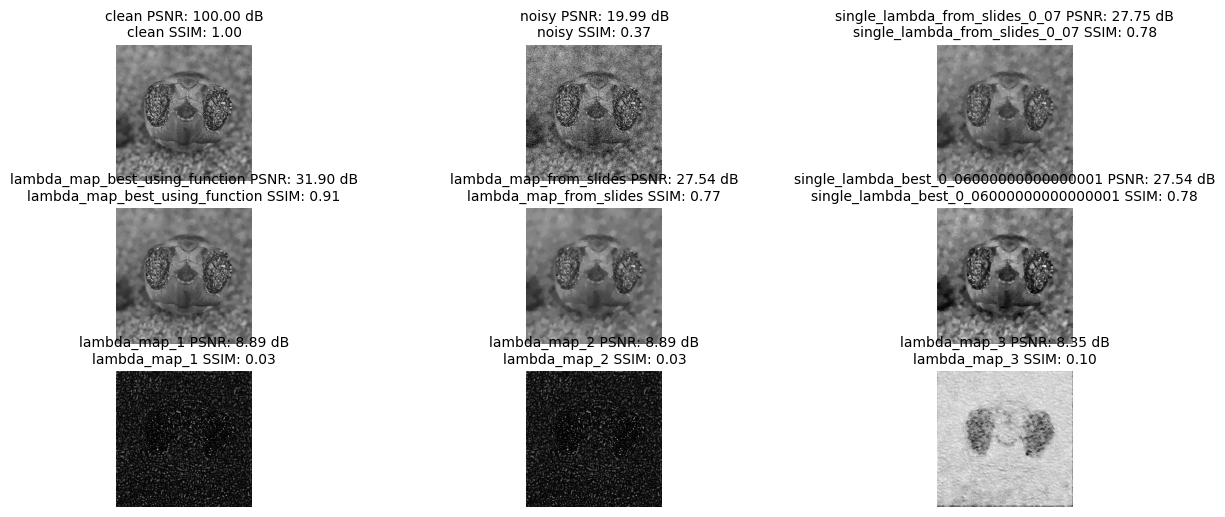

In [73]:
# CODE TO INFER AND SHOW SOME RESULTS HERE

def test_denoise(pdhg: DynamicImageStaticPrimalDualNN=None, model_name="", trained_on="", showing=False):
    """
    Testing denoising with pre-trained parameters.
    """


    # k_w, k_h = 192, 192
    k_w, k_h = 256, 256
    # best_lambda = 0.03 # Found by brute force on image 0065 kernel 192x192, sigma 0.3
    # best_lambda = 0.05 # Found by brute force on image 0065 kernel 512x512, sigma 0.3
    best_lambda = 0.07 # Turtle image, give in the slides
    # best_lambda = 0.085 # Found by brute force on image 0065 kernel 512x512, sigma 0.5
    # best_lambda = 0.2 # Found by brute force on image 0065 kernel 512x512, sigma 1
    # sigma = 0.3 
    # sigma = 0.5
    # sigma = 1
    # activation = "LeakyReLU"

    # Save the results
    # folder_name = f"./tmp/images/presentation-img_{img_id}-scale_{str(scale).replace('.', '_')}-sigma_{str(sigma).replace('.', '_')}-best_lambda_{str(best_lambda).replace('.', '_')}-kernel_{k_w}-model_{model_name}-activation_{activation}-trained_on_{trained_on}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
    folder_name = f"./tmp/images/presentation-img_{'turtle'}-best_lambda_{str(best_lambda).replace('.', '_')}-kernel_{k_w}-model_{model_name}-trained_on_{trained_on}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
    

    os.makedirs(folder_name, exist_ok=True)



    noisy_image_path = "./test_cases/turtle_noisy/turtle noisy.png"
    clean_image_path = "./test_cases/turtle_clean/turtle clean.png"
    denoised_image_single_lambda_slides_path = "./test_cases/turtle single lambda.png"
    denoised_image_lambda_map_slides_path = "./test_cases/turtle lambda map.png"

    def get_image_tensor_5D(image_path):
        image = Image.open(image_path)
        image = image.convert("L")
        image_numpy = np.asarray(image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        image_tensor_5D = image_tensor_4D.unsqueeze(0).to(DEVICE)
        return image_tensor_5D

    clean_image_tensor_5D = get_image_tensor_5D(clean_image_path)
    noisy_image_tensor_5D = get_image_tensor_5D(noisy_image_path)
    denoised_image_single_lambda_tensor_5D = get_image_tensor_5D(denoised_image_single_lambda_slides_path)
    denoised_image_lambda_map_slides_tensor_5D = get_image_tensor_5D(denoised_image_lambda_map_slides_path)

    plt.figure(figsize=(15, 6))
    num_rows = 3
    num_cols = 3
    def simple_plot(input_image_tensor_5D, subplot_index, image_name, clean_image_tensor_5D):
        plot_image_tensor_2D = input_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
        clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
        psnr_value = PSNR(clean_image_tensor_2D, plot_image_tensor_2D)
        ssim_value = SSIM(clean_image_tensor_2D, plot_image_tensor_2D)
        plt.subplot(num_rows, num_cols, subplot_index)
        plt.axis('off')
        plt.imshow(plot_image_tensor_2D.to("cpu").detach().numpy(), cmap='gray')
        plt.title(f"{image_name} PSNR: {psnr_value:.2f} dB\n{image_name} SSIM: {ssim_value:.2f}", fontsize=10)
        # Write the image to a file
        Image.fromarray((plot_image_tensor_2D.to("cpu").detach().numpy() * 255).astype(np.uint8)).save(f"{folder_name}/{image_name}.png")


    simple_plot(clean_image_tensor_5D, 1, "clean", clean_image_tensor_5D)
    simple_plot(noisy_image_tensor_5D, 2, "noisy", clean_image_tensor_5D)
    simple_plot(denoised_image_single_lambda_tensor_5D, 3, "single_lambda_from_slides_0_07", clean_image_tensor_5D)
    
    simple_plot(denoised_image_lambda_map_slides_tensor_5D, 5, "lambda_map_from_slides", clean_image_tensor_5D)
    
    pdhg.eval()

    # TODO: Brute-force single lambda
    best_psnr = 0
    best_lambda = 0
    for lambda_value in np.linspace(0.01, 0.1, 10):
        with torch.no_grad():
            x_denoised_single_lambda_tensor_5D = pdhg(noisy_image_tensor_5D, lambda_value)
        psnr_value = PSNR(clean_image_tensor_5D, x_denoised_single_lambda_tensor_5D)
        if psnr_value > best_psnr:
            best_psnr = psnr_value
            best_lambda = lambda_value
    
    with torch.no_grad():
        x_denoised_single_lambda_best_tensor_5D = pdhg(noisy_image_tensor_5D, best_lambda)

        best_lambda_map = pdhg.get_lambda_cnn(noisy_image_tensor_5D)
        x_denoised_lambda_map_best_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda_map, pdhg.T)


    # Clip to [0, 1]. The calculations may make it slightly below 0 and above 1
    x_denoised_single_lambda_best_tensor_5D = torch.clamp(x_denoised_single_lambda_best_tensor_5D, 0, 1)
    x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)

    simple_plot(x_denoised_lambda_map_best_tensor_5D, 4, "lambda_map_best_using_function", clean_image_tensor_5D)

    simple_plot(x_denoised_single_lambda_best_tensor_5D, 6, f"single_lambda_best_{str(best_lambda).replace('.', '_')}", clean_image_tensor_5D)

    lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
    lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
    lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]

    lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
    lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
    lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

    simple_plot(lambda_map_1, 7, "lambda_map_1", clean_image_tensor_5D)
    simple_plot(lambda_map_2, 8, "lambda_map_2", clean_image_tensor_5D)
    simple_plot(lambda_map_3, 9, "lambda_map_3", clean_image_tensor_5D)

    plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

# # Optional: Load model from storage
# model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_09_38_07_epoch_9774",
# model_folder=f"./tmp/states"
model_name="model_epoch_10000"
model_folder="./tmp_2/model_turtle_2024_06_04_04_19_21"

# # If loading from state_dicts, we need to initialise the model
# unet = UNet(dim=3, n_ch_in=1).to(DEVICE)
# total_params = sum(p.numel() for p in unet.parameters())
# print(f"UNet total parameters: {total_params}", file=log_file)
# pdhg_state_dicts = torch.load(f"{model_folder}/{model_name}.pt")
# pdhg = DynamicImageStaticPrimalDualNN(
#     cnn_block=unet, 
#     # T=128,
#     T=1000,
#     phase="training",
#     up_bound=0.5,
#     mode="lambda_cnn",
# ).to(DEVICE)
# pdhg.load_state_dict(pdhg_state_dicts)

# If loading from a state object, simply assign
pdhg = torch.load(f"{model_folder}/{model_name}.pt")

test_denoise(
    pdhg=pdhg,
    showing=True,
    # showing=False,
)


In [72]:
with torch.no_grad():
    torch.cuda.empty_cache()